In [5]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from IPython.display import clear_output
import time
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [3]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/553.3 kB ? eta -:--:--
   ------------------------------------- -- 524.3/553.3 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 553.3/553.3 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   -------------- ------------------------- 1.0/2.9 MB 2.7 MB/s eta 0:00:01
   --------------------- ------------------ 1.6/2.9 MB 2.7 MB/s eta 0:00:01
   -------------------------------- ------- 2.4/2.9 MB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 2.9/2.9 MB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/27.6 MB ? eta -:--:--
    --------------------------------------- 0.5/27.6 MB 3.4 MB/s eta 0:00:08
   - -------------------------------------- 1.3/27.6 MB 3.7 MB/s eta 0:00:08
   --- ------------------------------

  You can safely remove it manually.


In [7]:
from datasets import load_dataset

ds = load_dataset("ashraq/tmdb-celeb-10k",split='train')
ds = ds.select(range(1000))
ds = ds.filter(lambda x: x['gender'] in [1, 2])

ImportError: The pyarrow installation is not built with support for the Parquet file format (DLL load failed while importing _parquet: The specified module could not be found.)

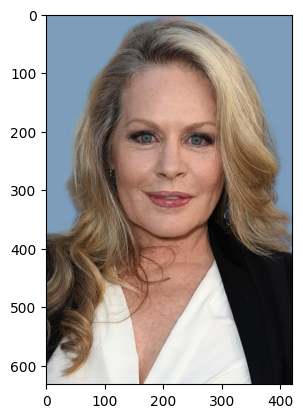

{'adult': False, 'also_known_as': '[]', 'biography': "Beverly D'Angelo (born November 15, 1951) is an American actress and singer.\n\nDescription above from the Wikipedia article Beverly D'Angelo, licensed under CC-BY-SA, full list of contributors on Wikipedia.", 'birthday': '1951-11-15', 'deathday': None, 'gender': 1, 'homepage': None, 'id': 821, 'imdb_id': 'nm0000350', 'known_for_department': 'Acting', 'name': "Beverly D'Angelo", 'place_of_birth': 'Columbus, Ohio, USA', 'popularity': 44.467, 'profile_path': '/8fYQIA8dAaA4GOTxOFSKIvTqzi.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=421x632 at 0x7F9A50823250>}


In [5]:
idx=100
plt.imshow(ds[idx]['image'])
plt.show()
print(ds[idx])

In [6]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([ transforms.Resize((64,64)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5],[0.5]),
])

def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]
    return examples

ds = ds.with_transform(transforms)

In [7]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        images.append((example["pixel_values"]))
        labels.append(example["gender"])
        
    pixel_values = torch.stack(images)
    labels = torch.tensor(labels).long() - 1
    return {"pixel_values": pixel_values, "label":labels}

dataloader = DataLoader(ds, collate_fn=collate_fn, batch_size=4)

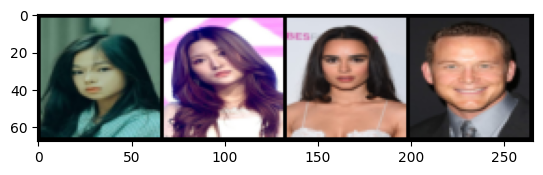

In [8]:
for batch in dataloader:
    print(batch["pixel_values"].shape)
    plt.imshow(torchvision.utils.make_grid(batch["pixel_values"]*0.5 + 0.5).permute(1,2,0).cpu().numpy())
    clear_output(wait=True)
    plt.show()
    print(batch["label"])
    break


# Use the Diffuser Library

In [9]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(beta_start=0.00085, 
                          beta_end=0.012, 
                          beta_schedule="scaled_linear", 
                          num_train_timesteps=1000)

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.36.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}



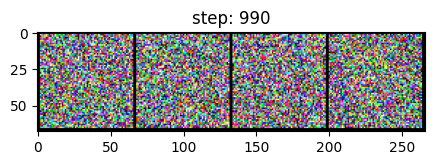

In [10]:
x = batch["pixel_values"]

for t in range(scheduler.num_train_timesteps):
    noise = torch.randn_like(x)
    
    x_noised = scheduler.add_noise(x, noise, torch.tensor(t).long())
    
    if t%10==0:
        plt.figure(figsize=(5,5))
        plt.title(f'step: {t}')
        plt.imshow(torchvision.utils.make_grid(x_noised*0.5 + 0.5).permute(1,2,0).cpu().numpy())
        clear_output(wait=True)
        plt.show()

# The Unet from the Diffusers Library

In [11]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    sample_size=64,
    in_channels = 3,
    out_channels = 3,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    
    down_block_types = ('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
    mid_block_type = 'UNetMidBlock2D',
    up_block_types = ('AttnUpBlock2D', 'AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'),
    block_out_channels= (64, 128, 160, 224),
    num_class_embeds=2
)

In [12]:
# count num of parameters in the model
print(f'Number of parameters in the model: {sum(p.numel() for p in unet.parameters())}')

Number of parameters in the model: 17642211


In [13]:
unet.to(device)
x=torch.randn(5,3,128,128).to(device)
t = torch.linspace(0,999,5).long().to(device)
label = torch.tensor([0,0,1,1,1]).long().to(device)


with torch.no_grad():
    output = unet(x,t,label)

In [17]:
from diffusers import DDIMScheduler

def generate_image():
    xt = torch.randn(4,3,64,64).to(device)
    label = torch.tensor([0,0,1,1]).long().to(device)
    
    inf_scheduler = DDIMScheduler.from_config(scheduler.config)
    inf_scheduler.set_timesteps(50)

    unet.eval()

    for t in tqdm(inf_scheduler.timesteps,total=inf_scheduler.num_inference_steps,leave=False):
        with torch.no_grad():
            noise_pred = unet(xt,t.to(device), label).sample
            
        
        xt = inf_scheduler.step(noise_pred, t.to(device), xt).prev_sample
        
    plt.figure(figsize=(10,3))
    plt.imshow(torchvision.utils.make_grid(xt*0.5 + 0.5).permute(1,2,0).cpu().numpy())
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

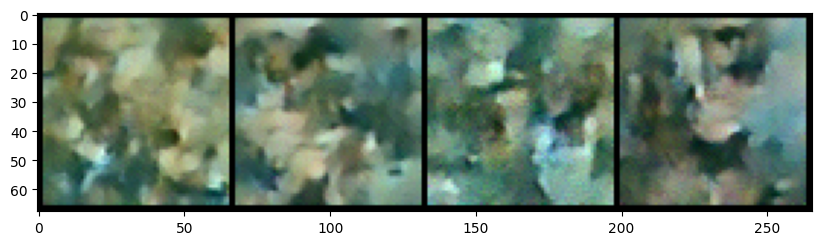

In [18]:
generate_image()

# Train the diffusion Model

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

num_steps: 500, loss: 0.026328


  0%|          | 0/50 [00:00<?, ?it/s]

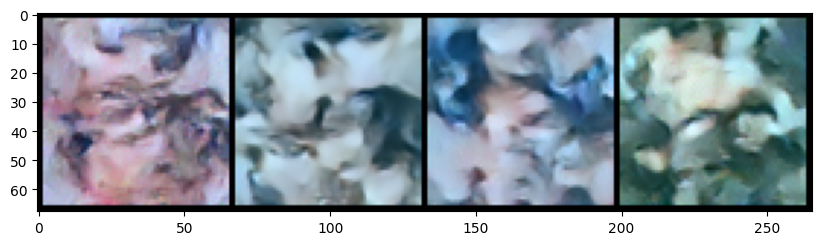

KeyboardInterrupt: 

In [19]:


# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.AdamW(unet.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

num_steps = 0
# The training loop
while num_steps < 50000:
    for batch in tqdm(dataloader,total=len(dataloader),leave=False):
        
        # Get some data and prepare the corrupted version
        x = batch['pixel_values'].to(device) 
        y = batch['label'].long().to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = unet(noisy_x, timesteps, y).sample # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        num_steps += 1

        # Store the loss for later
        losses.append(loss.item())
    
        if num_steps % 500 == 0:
            avg_loss = sum(losses[-100:])/100
            print(f'num_steps: {num_steps}, loss: {avg_loss:05f}')
            generate_image()


        